# Optimization for Collabrative filtering

## Imports

In [36]:
import numpy as np
import pandas as pd
import lenskit.crossfold as xf
import matplotlib.pyplot as plt
from lenskit.metrics.predict import rmse
from lenskit.algorithms.bias import Bias
from lenskit.batch import predict



# A. Preprocessing of data

1. Data format

We are going to preprocess a rating file in the following csv format:  
```
UserID::MovieID::Rating::Timestamp
```

2. Prepare data for cross-validation

Splitting Data for a user-based N-fold cross-validation. Store each partition into a new csv file. 

It is convinient to use a python package lenskit. It can be installed by following https://lkpy.readthedocs.io/en/stable/install.html

Use the function lenskit.crossfold.partition_rows to partition all the ratings into N train-test partitions.

3. Convert to a list format

Convert data into a list format for fast processing


In [4]:
# read a DataFrame of ratings from the csv ratings file
csvroot = 'data' 
ratings = pd.read_csv(csvroot + '/ratings.csv')
ratings = ratings.rename(columns={'userId': 'user', 'movieId': 'item'})


def unique(list1):
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    # use a dictionary to store the index of each element in the list
    unique_dict = {}
    for i in range(len(unique_list)):
        unique_dict[unique_list[i]] = i 
    return unique_list, unique_dict

lst_users, dic_users = unique(ratings['user'])
lst_items, dic_items = unique(ratings['item'])
M = len(lst_users)
N = len(lst_items)

matrixSparsity = len(ratings) / (M*N)
print("We have %d users, %d movies and the %d ratings matrix has %f percent of non-zero value.\n" % (M, N,ratings.shape[0],100*matrixSparsity))

We have 610 users, 9724 movies and the 100836 ratings matrix has 1.699968 percent of non-zero value.



In [5]:
# 2 fold cross-validation, store each partition (both train and test) in a seperate csv file.
# Point 1: report the number of (user,iter,rating) items in each file.
df = ratings

# Create 2 folds using partition_rows
folds = xf.partition_rows(df, 2)

# Iterate over the folds and write each partition to a separate CSV file
for i, (train, test) in enumerate(folds):
    
    train = train.rename(columns={'userId': 'user', 'movieId': 'item'})
    test = test.rename(columns={'userId': 'user', 'movieId': 'item'})

    train.to_csv(f'data/train_{i}.csv', index=False)
    test.to_csv(f'data/test_{i}.csv', index=False)
    

    # Print the number of (user, item, rating) items in each partition
    print(f'fold {i}')


    lst_users, dic_users = unique(train['user'])
    lst_items, dic_items = unique(train['item'])
    Ml = len(lst_users)
    Nl = len(lst_items)
    matrixSparsity = len(ratings) / (M*N)
    print("We have %d users, %d movies and %d rating \n" % (Ml, Nl,train.shape[0]))


    lst_users, dic_users = unique(test['user'])
    lst_items, dic_items = unique(test['item'])
    Ml = len(lst_users)
    Nl = len(lst_items)

    print("We have %d users, %d movies and %d rating \n" % (Ml, Nl,test.shape[0]))
    



fold 0
We have 610 users, 7494 movies and 50418 rating 

We have 610 users, 7544 movies and 50418 rating 

fold 1
We have 610 users, 7544 movies and 50418 rating 

We have 610 users, 7494 movies and 50418 rating 



In [6]:
def convert_DF_to_RDD(DF):
    """ 
    This function converts a rating dataframe into a dictionary of lists
    Args:
        DF: a dataframe which contains 'user', 'item' and 'rating' columns
    Returns:
        RDD: a dictionary which contains 
            'total': the total number of rating
            'users': a list of user id for each rating
            'items': a list of item id for each rating
            'ratings': a list of ratings
    """ 
    RDD = {'total':0,'users':[],'items':[],'ratings':[]} 
    
    # Get the total number of ratings
    RDD['total'] = DF.shape[0]
    
    # Extract the values for the 'user', 'item', and 'rating' columns
    RDD['users'] = DF['user'].values
    RDD['items'] = DF['item'].values
    RDD['ratings'] = DF['rating'].values
    
    return RDD

In [7]:
# read the csv files from a partition of the cross-validation
# convert them to RDD using convert_DF_to_RDD

# Read the train and test sets for a specific fold 0 from CSV files
train_0_df = pd.read_csv(csvroot+ '/train_0.csv')
test_0_df = pd.read_csv(csvroot+ '/test_0.csv')

# Convert the train and test sets to RDDs using convert_DF_to_RDD
train_0_rdd = convert_DF_to_RDD(train_0_df)
test_0_rdd = convert_DF_to_RDD(test_0_df)


# Read the train and test sets for a specific fold 1 from CSV files
train_1_df = pd.read_csv(csvroot+ '/train_1.csv')
test_1_df = pd.read_csv(csvroot+ '/test_1.csv')

# Convert the train and test sets to RDDs using convert_DF_to_RDD
train_1_rdd = convert_DF_to_RDD(train_1_df)
test_1_rdd = convert_DF_to_RDD(test_1_df)


# B. Gradient-descent algorithm

Based on the preprocessing, we are going to develop a method to find optimal P and Q on training data. It contains: 

1. compute the objective and the gradient of the objective function
2. implement the gradient-descent algroithm
3. measure the speed of this method

In [8]:
# assume now you have obtained trainRDD and testRDD
# Compute the objective funtion

def computeMSE(RDD,P,Q,la=0):
    """ 
    This function computes regularized Mean Squared Error (MSE)
    Args:
        RDD: a dict of list of userID, itemID, Rating
        P: user's features matrix (M by K)
        Q: item's features matrix (N by K)
        la: lambda parameter for regulization (see definition in the project description)
    Returns:
        mse: mean squared error
    """ 
    
    # Get the number of ratings and the lists of user IDs, item IDs, and ratings from the RDD
    N = RDD['total']
    users = RDD['users']
    items = RDD['items']
    ratings = RDD['ratings']
    unique_items, items_dict = unique(items)
    users_items, users_dict = unique(users)
    
    # Initialize the squared error sum to 0
    squared_error_sum = 0
    
    # Iterate over the ratings
    for i in range(N):
        # Get the user ID and item ID for the current rating
        u = users_dict[users[i]]
        j = items_dict[items[i]]
        
        # Get the user and item feature vectors
        p = P[u]
        q = Q[j]
        
        # Compute the error for the current rating
        r = ratings[i]
        error = r - np.dot(p, q)
        
        # Add the squared error to the sum
        squared_error_sum += error ** 2
        
        # Regularize the error by adding the penalty term
        squared_error_sum += la * (np.sum(np.maximum(p, 0)** 2) + np.sum(np.maximum(q, 0)** 2))
    
    # Compute the MSE by dividing the squared error sum by the number of ratings
    mse = squared_error_sum / N
    
    return mse    

In [9]:
# use a random P and Q to test the function computeMSE
# Point 2: report MSE with LAMBDA=0

K = 5 # rank parameter
P = np.random.rand(M,K) # user's features matrix (M by K)
Q = np.random.rand(N,K) # item's features matrix (N by K)

ratings_rdd = convert_DF_to_RDD(ratings)
print('MSE =',  computeMSE(ratings_rdd,P,Q))

MSE = 6.491954686349045


In [10]:
# Compute the gradient of the objective funtion
def computeGradMSE(RDD,P,Q,la=0):
    """ 
    This function computes the gradient of regularized MSE with respect to P and Q
    Args:
        RDD: a dict of list of userID, itemID, Rating
        P: user's features matrix (M by K)
        Q: item's features matrix (N by K)
    Returns:
        gradP, gradQ: gradient of mse with respect to each element of P and Q 
    """ 
    
   # Get the number of ratings and the lists of user IDs, item IDs, and ratings from the RDD
    N = RDD['total']
    users = RDD['users']
    items = RDD['items']
    ratings = RDD['ratings']
    unique_items, items_dict = unique(items)
    users_items, users_dict = unique(users)
    
    # Get the number of users and items
    M = P.shape[0]
    N = Q.shape[0]
    
    # Get the number of features
    K = P.shape[1]
    
    # Initialize the gradient matrices to zero
    gradP = np.zeros((M, K))
    gradQ = np.zeros((N, K))

    # Loop through the ratings
    for idx in range(N):
        # Get the user ID and item ID for the current rating
        user_id = users_dict[users[idx]]
        item_id = items_dict[items[idx]]
        p = P[user_id]
        q = Q[item_id]
        
        # Get the rating for the current user and item
        rating = ratings[idx]
        
        # Compute the error between the prediction and the actual rating
        error = rating - np.dot(p, q)
        
        # Compute the gradients with respect to P and Q
        gradP[user_id] = gradP[user_id] - 2 * error * q
        gradQ[item_id] = gradQ[item_id] - 2 * error * p

    # Add the regularization terms to the gradients
    gradP = gradP + 2 * la * P
    gradQ = gradQ + 2 * la * Q

    return gradP, gradQ

    

In [21]:
def line_search(RDD, P, Q, dP, dQ, LAMBDA, GAMMA, mse):
    # Update P and Q using the step size and gradients
    P_new = P + GAMMA * dP
    Q_new = Q + GAMMA * dQ

    # Calculate the MSE for the updated matrices
    mse_new = computeMSE(RDD, P_new, Q_new, LAMBDA)

    # If the MSE has decreased, return the updated matrices and step size
    if mse_new < mse:
        return P_new, Q_new, GAMMA

    # If the MSE has not decreased, reduce the step size and try again
    GAMMA /= 2

    # If the MSE has not decreased after the specified number of iterations, return the original matrices and step size
    return P, Q, GAMMA

In [23]:
# implement the (steepest) gradient-descent algorithm

### TODO


def GD(RDD,M,N,K,MAXITER=50, GAMMA=0.001, LAMBDA=0.05, adaptive=0):
    """ 
    This function implemnts the gradient-descent method to minimize the regularized MSE with respect to P and Q
    Args:
        RDD: a dict of list of users, items, ratings
        M: number of users
        N: number of items
        K: rank parameter
        MAXITER: maximal number of iterations (epoches) of GD 
        GAMMA: step size of GD
        LAMBDA: regulization parameter lambda in the mse loss
        adaptive: if 0 then use constant step size GD, 
                  if 1 then use line search to choose the step size automatically
    Returns:
        P: optimal P found by GD
        Q: optimal Q found by GD
        lreg_mse: a list of regulized mse values evaluated on RDD, after each iteration
        lmse: a list of mse values, evaluated on RDD after each iteration
        other scores for analysis purpose
    """ 
    
    # Initialize the user and item feature matrices to random values
    P = np.random.rand(M, K)
    Q = np.random.rand(N, K)    
    # Initialize the lists to store the MSE and regularized MSE after each iteration
    lreg_mse = []
    lmse = []
    
    # Initialize the iteration counter
    iter = 0
    mse = 0
    
    # Run the gradient descent loop
    while iter < MAXITER:
        # Compute the gradients ofthe regularized MSE loss with respect to P and Q
        dP, dQ = computeGradMSE(RDD, P, Q, LAMBDA)
        # Update P and Q using gradient descent
        if adaptive == 0:
            # Use constant step size
            P = P - GAMMA * dP
            Q = Q - GAMMA * dQ
        else:
            # Use line search to find the optimal step size
            P, Q, GAMMA = line_search(RDD, P, Q, dP, dQ, LAMBDA, GAMMA, mse)
        
        # Compute the regularized MSE and MSE on the training set

        mse = computeMSE(RDD, P, Q)
        reg_mse = computeMSE(RDD, P, Q, LAMBDA)
        
        # Append the errors to the lists
        lreg_mse.append(reg_mse)
        lmse.append(mse)
        
        # Increment the iteration counter
        iter += 1

    return P, Q, lreg_mse, lmse



In [12]:
# Compare GD constant step size with GD line search step size
# Point 3: Make plots to show how (regularized) MSE changes with respect to GD iterations 
# Mention your initialization of P,Q, and the stopping criterion of GD

### TODO



/tmp/ipykernel_556423/1097256183.py:45: RuntimeWarning: overflow encountered in square
  squared_error_sum += la * (np.sum(np.maximum(p, 0)** 2) + np.sum(np.maximum(q, 0)** 2))
/tmp/ipykernel_556423/1097256183.py:45: RuntimeWarning: invalid value encountered in scalar multiply
  squared_error_sum += la * (np.sum(np.maximum(p, 0)** 2) + np.sum(np.maximum(q, 0)** 2))
/tmp/ipykernel_556423/1097256183.py:42: RuntimeWarning: overflow encountered in scalar power
  squared_error_sum += error ** 2
/home/n7student/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/tmp/ipykernel_556423/350889051.py:47: RuntimeWarning: overflow encountered in multiply
  gradP[user_id] = gradP[user_id] - 2 * error * q
/tmp/ipykernel_556423/350889051.py:48: RuntimeWarning: overflow encountered in multiply
  gradQ[item_id] = gradQ[item_id] - 2 * error * p
/tmp/ipykernel_556423/2688719454.py:45: Ru

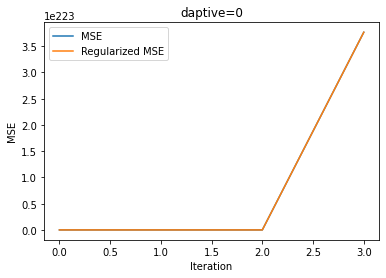

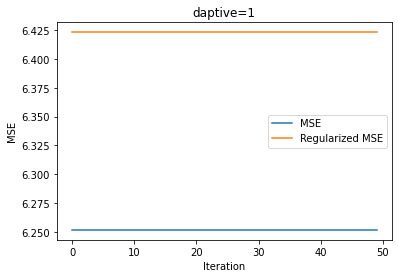

In [38]:
def run_gd(RDD, M, N, K, MAXITER, GAMMA, LAMBDA, adaptive):
    # Run the gradient descent algorithm
    P, Q, lreg_mse, lmse = GD(RDD, M, N, K, MAXITER, GAMMA, LAMBDA, adaptive)
    
    # Plot the MSE at each iteration
    plt.plot(range(MAXITER), lmse, label='MSE')
    plt.plot(range(MAXITER), lreg_mse, label='Regularized MSE')
    plt.xlabel('Iteration')
    plt.ylabel('MSE')
    plt.title(f'daptive={adaptive}')
    plt.legend()
    plt.show()

# Set the hyperparameters
MAXITER = 50
GAMMA = 0.1
LAMBDA = 0.05

# Generate random data for RDD
RDD =ratings_rdd

# Run the gradient descent algorithm with a constant step size
run_gd(RDD, M, N, K, MAXITER, GAMMA, LAMBDA, adaptive=0)

# Run the gradient descent algorithm with a line search step size
run_gd(RDD, M, N, K, MAXITER, GAMMA, LAMBDA, adaptive=1)


# C. Perofomance evaluation
1. Compute RMSE score. You should use lenskit.metrics.predict.rmse for a fair comparison. Analyze both the training and test score on the 5 cross-validation partitions. 
2. Compare with a baseline method called Bias. Tune the hyper-parameters such as K and lambda to see if you can obtain a smaller RMSE. Try to explain why. 

In [ ]:
# Point 4: Report RMSE, together with your choice of K,LAMBDA and GD parameters

from lenskit.metrics.predict import rmse

def evaluteRMSE(RDD,P,Q):
    """ 
    This function computes the root MSE score on the rating of RDD. It compares the rating of each (i,j)
    in RDD, with the prediction made by <p_i,q_j>. 
    Args:
        RDD: a dict of list of users, items, ratings
        P: optimal P found by GD
        Q: optimal Q found by GD
    Returns:
        RMSE: the RMSE score
    """
    
    ### TODO
    

### TODO


In [33]:

def evaluate_rmse(RDD, P, Q):
    """ 
    This function computes the root MSE score on the rating of RDD. It compares the rating of each (i,j)
    in RDD, with the prediction made by <p_i,q_j>. 
    Args:
        RDD: a dict of list of users, items, ratings
        P: optimal P found by GD
        Q: optimal Q found by GD
    Returns:
        RMSE: the RMSE score
    """
    
    # Get the lists of users, items, and ratings from the RDD
    users = RDD['users']
    items = RDD['items']
    ratings = RDD['ratings']
    unique_items, items_dict = unique(items)
    users_items, users_dict = unique(users)
    
    # Initialize a list to store the predicted ratings
    preds = []
    
    # Loop through the ratings
    for idx in range(len(ratings)):
        # Get the user ID and item ID for the current rating
        user_id = users_dict[users[idx]]
        item_id = items_dict[items[idx]]
        p = P[user_id]
        q = Q[item_id]
        
        # Compute the predicted rating using the dot product of P and Q
        rating = np.dot(p,q)
        
        # Append the predicted rating to the list
        preds.append(rating)
    
    # Compute the RMSE score
    rmse_score = rmse(ratings, preds)
    
    return rmse_score

rmse_score = evaluate_rmse(ratings_rdd,P,Q)
print(rmse_score)


2.5479314524431538


In [ ]:
# Compare the performance with a baseline method called Bias
# see in https://lkpy.readthedocs.io/en/stable/bias.html
# Point 5:  report the RMSE of the baseline method, and analyze the results
# Hint: use read_csv in panda to read you csv data

from lenskit.algorithms.bias import Bias
from lenskit.batch import predict

### TODO


In [39]:
# Split the data into training and test sets
train_df = train_0_df
test_df = test_0_df

# Train the Bias model on the training data
model = Bias()
model.fit(train_df)

# Make predictions on the test data
predictions = predict(model, test_df)

# Calculate the RMSE of the predictions
rmse = np.sqrt(rmse(predictions.rating, test_df.rating))
print(f'RMSE of Bias method: {rmse}')


Exception in initializer:
Traceback (most recent call last):
  File "/usr/lib/python3.9/concurrent/futures/process.py", line 230, in _process_worker
    initializer(*initargs)
  File "/home/n7student/.local/lib/python3.9/site-packages/lenskit/util/parallel.py", line 106, in _initialize_mp_worker
    _initialize_worker(log_queue, seed)
  File "/home/n7student/.local/lib/python3.9/site-packages/lenskit/util/parallel.py", line 95, in _initialize_worker
    init_rng(seed)
  File "/home/n7student/.local/lib/python3.9/site-packages/lenskit/util/random.py", line 58, in init_rng
    seedbank.initialize(seed, *keys)
  File "/home/n7student/.local/lib/python3.9/site-packages/seedbank/__init__.py", line 59, in initialize
    mod = import_module(mod)
  File "/usr/lib/python3.9/importlib/__init__.py", line 127, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1030, in _gcd_import
  File "<frozen importlib._bootstrap>", lin

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.